## Visual Geometry Group Models (VGG16 & VGG19)
Documentation to be filled up later BLABLABLA

### Installation and Import Checks

In [87]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline
%pip install keras_tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [88]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import keras_tuner as kt
# Plotting
import matplotlib.pyplot as plt

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [89]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. 

In [90]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is output hot coded
y_output = to_categorical(y_output, num_classes=4)
# Resizes images to 224 x 224 for optimal size for VGG models
x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

Splits for training and testing 80/20 ratio

In [91]:
# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 384
Number of Classes: 4


### Optional: Hyperparameter Optimisation
For hyperparameter optimisation, the team experimented with the keras tuner on the simpler VGG model VGG16. We created a function that iterates through different models builds trying out different number of neurons, dropout and learning rates to see which works best for the model, which will be used as the most optimal parameters for our trained model subsequently. 

In [92]:
# # Function to build the model
# def build_model(hp):
#     base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
#     for layer in base_vgg16_model.layers:
#         layer.trainable = False

#     x = base_vgg16_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
    
#     # Tune the number of units in the first dense layer
#     units_1 = hp.Int('units_1', min_value=512, max_value=1024, step=128)
#     x = Dense(units_1, activation='relu', kernel_constraint=max_norm(3))(x)
    
#     # Tune the dropout rate
#     dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
#     x = Dropout(dropout_1)(x)
    
#     # Tune the number of units in the second dense layer
#     units_2 = hp.Int('units_2', min_value=256, max_value=512, step=128)
#     x = Dense(units_2, activation='relu', kernel_constraint=max_norm(3))(x)
    
#     # Tune the dropout rate
#     dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
#     x = Dropout(dropout_2)(x)
    
#     new_output_layer_vgg16 = Dense(4, activation='softmax')(x)  # 4 classes: no tumor, glioma, meningioma, pituitary
    
#     model = Model(inputs=base_vgg16_model.input, outputs=new_output_layer_vgg16)
    
#     # Tune the learning rate
#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

In [93]:
# # Set up the tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=30,
#     executions_per_trial=1,
#     directory='kt_tuner_vggtest'
#     project_name='brain_tumor_classification'
# )

# # Define callbacks
# checkpoint = ModelCheckpoint('model_checkpoints/vgg16_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# # Run the hyperparameter search
# tuner.search(x_input_train, y_output_train, epochs=25, validation_data=(x_input_test, y_output_test), callbacks=[checkpoint, early_stopping])

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
# The optimal dropout rate for the first dropout layer is {best_hps.get('dropout_1')}.
# The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
# The optimal dropout rate for the second dropout layer is {best_hps.get('dropout_2')}.
# The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
# """)

### Loading and Defining VGG16 & VGG19 Model
In this step, we define our base model by call the pretrained VGG models from Tensorflow. The model is loaded with the weightages trained from the ImageNet dataset and we define the inputs dimensions that model should expect. We also remove the top output layer such that we can add it on later. These layers are our base models that will not be changed. 
* weights='imagenet' > Loads weightages from ImageNet data training
* include_top = False > Exclude top layers of model, to add custom top layers (tuning with our data)
* input_shape > Specify the dimensions of our input data, which is given as 224 x 224 pixels and 3 representing color channels in each image (RGB)



In [94]:
# # Load the VGG16 model pre-trained on ImageNet
# base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [95]:
# Load the VGG19 model pre-trained on ImageNet
base_vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

After we drop the last output layer, we need to define our own layers to supplement the base model which will be used to fine tune the model to our specific needs. These models will not be frozen and will be manipulated and affected by the the data we feed in. For the other existing models within VGG, we freeze them to avoid amending them. 

Resources for Layering Operations:
* How Global Average Pooling works: https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/#:~:text=with%20nine%20elements.-,What%20is%20GlobalAveragePooling2D()%20in%20Keras%3F,an%20operation%20on%20the%20data.
* How Batch Normalisation works: https://arxiv.org/abs/1502.03167
* How kernal constraints works: https://keras.io/api/layers/constraints/#:~:text=MaxNorm%20class&text=Constrains%20the%20weights%20incident%20to,max_norm%20.
* How dropout layers works: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout#:~:text=The%20Dropout%20layer%20randomly%20sets,over%20all%20inputs%20is%20unchanged.


In [96]:
# # Adds average pool layer to reduce dimensionality of feature maps
# new_layers_vgg16 = GlobalAveragePooling2D()(base_vgg16_model.output)
# # Adds a normalisation layer to enhance performance with bigger batch sizes (32)
# new_layers_vgg16 = BatchNormalization()(new_layers_vgg16)
# # Add first dense layer of 1024 neurons with RELU, adds weight constraints, regularising weights directly
# new_layers_vgg16 = Dense(1024, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg16)
# # Add first dropout layer with 20% dropout rate to avoid overfitting   
# new_layers_vgg16 = Dropout(0.2)(new_layers_vgg16)
# # Add second dense layer of 384 neurons with RELU, adds weight constraints, regularising weights directly
# new_layers_vgg16 = Dense(384, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg16)
# # Add second dropout layer with 20% dropout rate to avoid overfitting  
# new_layers_vgg16 = Dropout(0.2)(new_layers_vgg16)
# # Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
# output_layer_vgg16 = Dense(4, activation='softmax')(new_layers_vgg16)

# # Define the model
# vgg16_brain_tumor_model = Model(inputs=base_vgg16_model.input, outputs=output_layer_vgg16)

# # Freeze the layers of the base model
# for layer in base_vgg16_model.layers:
#     layer.trainable = False

In [101]:
# Adds average pool layer to reduce dimensionality of feature maps
new_layers_vgg19 = GlobalAveragePooling2D()(base_vgg19_model.output)
# Adds a normalisation layer to enhance performance with bigger batch sizes (32)
new_layers_vgg19 = BatchNormalization()(new_layers_vgg19)
# Add first dense layer of 1024 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg19 = Dense(1024, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg19)
# Add first dropout layer with 20% dropout rate to avoid overfitting   
new_layers_vgg19 = Dropout(0.2)(new_layers_vgg19)
# Add second dense layer of 384 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg19 = Dense(384, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg19)
# Add second dropout layer with 20% dropout rate to avoid overfitting  
new_layers_vgg19 = Dropout(0.2)(new_layers_vgg19)
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
output_layer_vgg19 = Dense(4, activation='softmax')(new_layers_vgg19)

# Define the model
vgg19_brain_tumor_model = Model(inputs=base_vgg19_model.input, outputs=output_layer_vgg19)

# Freeze the layers of the base model
for layer in base_vgg19_model.layers:
    layer.trainable = False

### Training the VGG16 & VGG19 Models


In [98]:
# # Compile the model
# vgg16_brain_tumor_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks
# checkpoint_vgg16 = ModelCheckpoint('model_checkpoints/vgg16_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping_vgg16 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# # Train the model
# trained_vgg16_model = vgg16_brain_tumor_model.fit(x_input_train, y_output_train, epochs=25, validation_data=(x_input_test, y_output_test), 
#                     callbacks=[checkpoint_vgg16, early_stopping_vgg16])

In [102]:
# Compile the model
vgg19_brain_tumor_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_vgg19 = ModelCheckpoint('/model_checkpoints/vgg19_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
trained_vgg19_model = vgg19_brain_tumor_model.fit(x_input_train, y_output_train, epochs=25, validation_data=(x_input_test, y_output_test), 
                    callbacks=[checkpoint_vgg19, early_stopping_vgg19])

Epoch 1/25
48/48 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.6999
Epoch 1: val_loss improved from inf to 1.11063, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 5s 101ms/step - loss: 0.7279 - accuracy: 0.6999 - val_loss: 1.1106 - val_accuracy: 0.6484
Epoch 2/25
48/48 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.8724
Epoch 2: val_loss did not improve from 1.11063
48/48 [==============================] - 4s 89ms/step - loss: 0.3563 - accuracy: 0.8724 - val_loss: 1.1176 - val_accuracy: 0.5885
Epoch 3/25
48/48 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.9095
Epoch 3: val_loss improved from 1.11063 to 0.93150, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 4s 89ms/step - loss: 0.2595 - accuracy: 0.9095 - val_loss: 0.9315 - val_accuracy: 0.6667
Epoch 4/25
48/48 [==============================] - ETA: 0s - 

### Plotting VGG Model Performances

In [ ]:
def plot_model_performance(history, title):
    """
    Plot training and validation loss and accuracy.

    Parameters:
    - history: Keras History object
    - title: str, title of the plot
    """
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix the accuracy scale from 0 to 1
    plt.yticks([i/10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()

    plt.suptitle(title)
    plt.show()

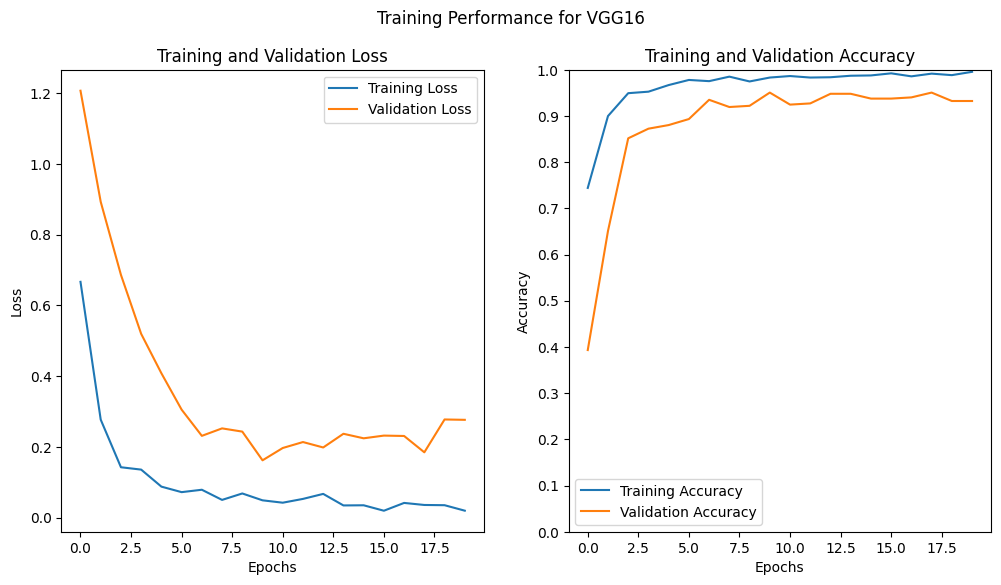

In [ ]:
# plot_model_performance(trained_vgg16_model, "Training Performance for VGG16")
plot_model_performance(trained_vgg19_model, "Training Performance for VGG19")